# Evaluation

The goal of this lab is to introduce you to techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We will work with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. The iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family: iris setosa, iris versicolor, iris virginica. Our version of the data set has 150 data points with 50 for each class.

In [76]:
# Load the data
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


We try to classify the iris versicolor with the help of the first two features.

In [77]:
import numpy as np

X_versi = X[:, :2] 
y_versi = np.zeros(len(y))
y_versi[y == 1] = 1

In [78]:
X_versi[y_versi == 1,0]

array([7. , 6.4, 6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. ,
       6.1, 5.6, 6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6,
       6.8, 6.7, 6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6,
       5.5, 5.5, 6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7])

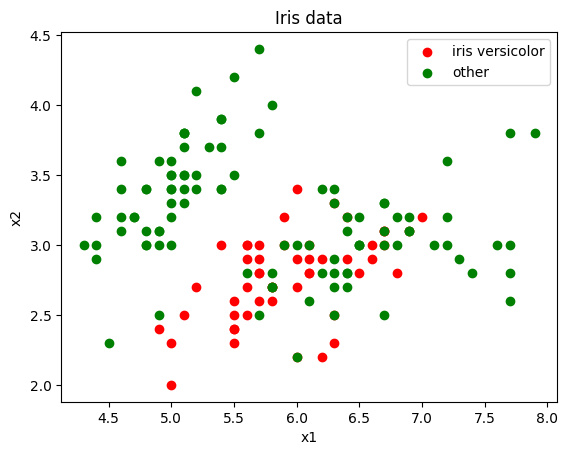

In [79]:
# plot iris data with two features
plt.scatter(X_versi[y_versi == 1, 0], X_versi[y_versi == 1, 1], c='red', label='iris versicolor')
plt.scatter(X_versi[y_versi == 0, 0], X_versi[y_versi == 0, 1], c='green', label='other')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title('Iris data')
plt.legend()
plt.show()

We split the data into a train and test (holdout) set with a split ratio of 75% to 25%.

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=3)

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [81]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    except AttributeError:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

We now train a SVM classifier on the training data and plot its decision boundary.

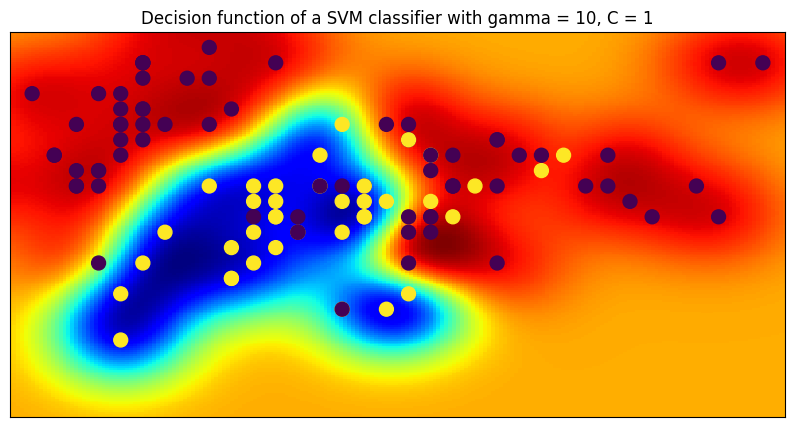

In [82]:
from sklearn.svm import SVC

clf_svm = SVC(gamma=10, C=1, probability=True)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1');

#### Exercise 1.1 (Performance measures)
Classify the test data and evaluate the classification performance of the trained model 'clf_svm' using the scikit-learn metrics package. Compare various metrics (classification accuracy, precision, recall, f-score), interpret their values and argue which of them might be the most meaningful to report.

In [173]:
from sklearn import metrics

####################
# preds = clf_svm.predict(X_test) # Why not to use this ?
preds = clf_svm.predict(X_test)

accuracy = metrics.accuracy_score(y_test,preds)
precision = metrics.precision_score(y_test,preds)
recall = metrics.recall_score(y_test,preds)
f1_score = metrics.f1_score(y_test,preds)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1_Score: {f1_score}")
####################

Accuracy: 0.7631578947368421
Precision: 0.6666666666666666
Recall: 0.5
F1_Score: 0.5714285714285715


#### Exercise 1.2 (ROC curve)

To further evaluate the model, we want to plot a ROC (Receiver operating characteristic) curve and look at the AUC (area under the curve) value. Therefore, we provide a function "plot_roc_curves" that accepts increasing false positive rates (fprs) and true positive rates (tprs) and plots the curve for you. 

Please calculate the false and true positive rates of the classifier 'clf_svm' on the test data 'X_test' and draw the ROC curve by executing the function 'plot_roc_curves'. What does the ROC and AUC tell us about the classifier's performance?

In [163]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [164]:
def get_tpr_fpr(y_true, y_pred):
    sorted_indices = sorted(range(len(y_pred)), key=lambda k: y_pred[k], reverse=True)
    sorted_y_true = [y_true[i] for i in sorted_indices]
    sorted_y_pred = [y_pred[i] for i in sorted_indices]

    thresholds = sorted(set(sorted_y_pred), reverse=True)
    tpr = []
    fpr = []

    for threshold in thresholds:
        y_pred_binary = [1 if p >= threshold else 0 for p in sorted_y_pred]

        tp = sum(1 for p, t in zip(y_pred_binary, sorted_y_true) if p == 1 and t == 1)
        fp = sum(1 for p, t in zip(y_pred_binary, sorted_y_true) if p == 1 and t == 0)
        tn = sum(1 for p, t in zip(y_pred_binary, sorted_y_true) if p == 0 and t == 0)
        fn = sum(1 for p, t in zip(y_pred_binary, sorted_y_true) if p == 0 and t == 1)

        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))

    return np.array(fpr), np.array(tpr)

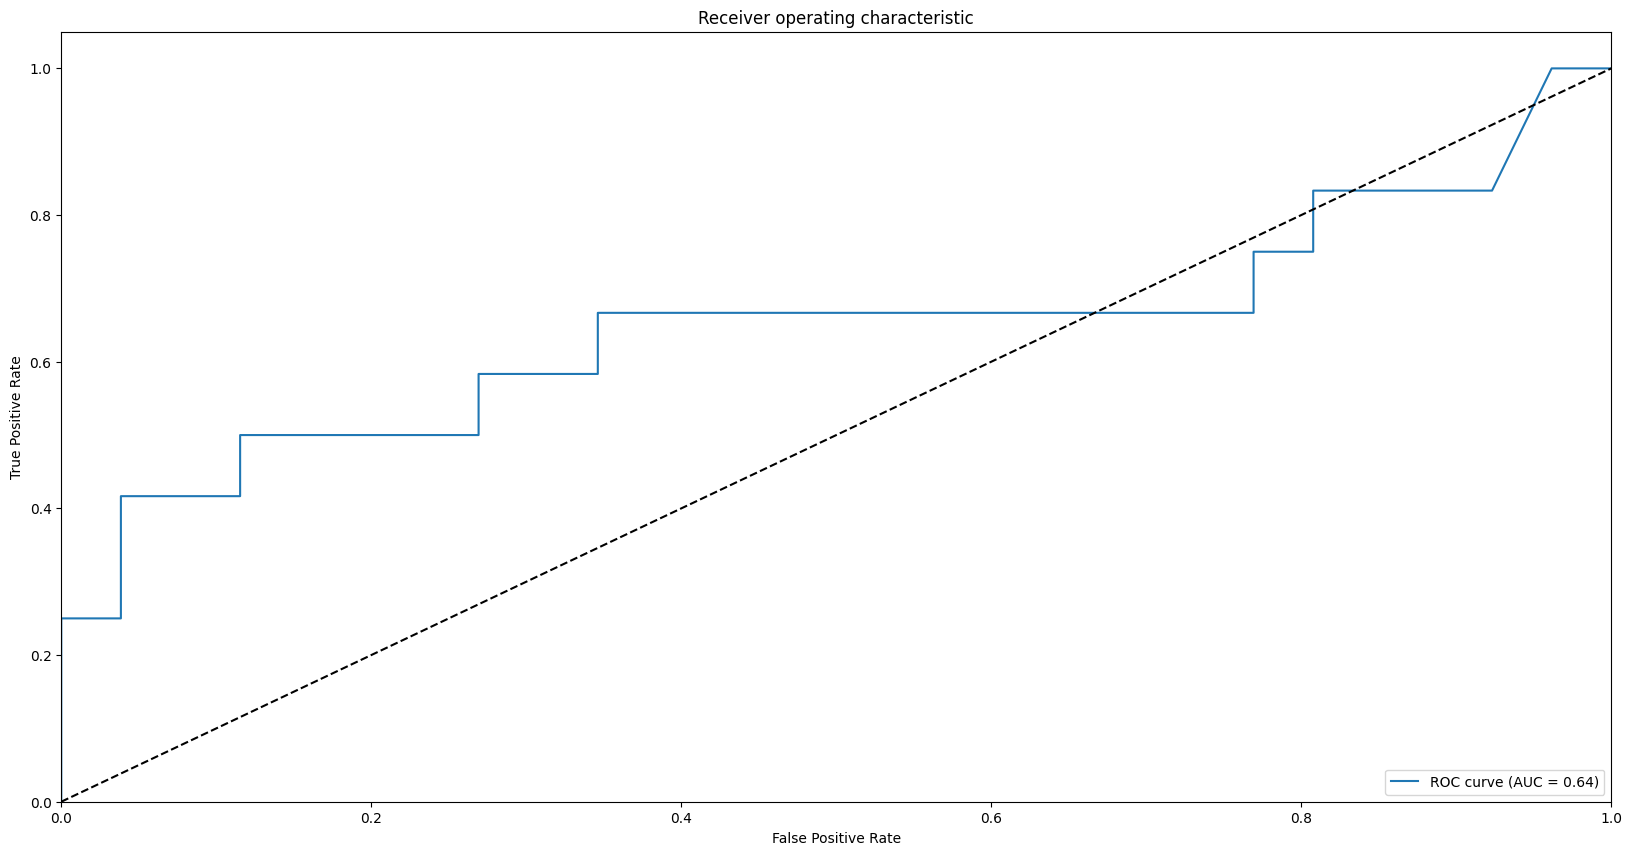

In [229]:
preds_proba = clf_svm.decision_function(X_test)
fprs, tprs = [],[]
fprs_,tprs_ = [],[]
fpr, tpr, thresholds = metrics.roc_curve(y_test,preds_proba)
fprs.append(fpr)
tprs.append(tpr)


fpr_, tpr_ = get_tpr_fpr(y_test,preds_proba)
fprs_.append(fpr)
tprs_.append(tpr)

plot_roc_curves(fprs,tprs)
# plot_roc_curves(fprs_,tprs_)

#### Exercise 1.3 (Model comparison)

Train four more SVM models on the training data by varying the regularization parameter $C$ (the gamma parameter can be set to 10 again). Put the models into a list 'clfs' using the append method. You can add a name to each classifier by setting clf.name = "some description" to keep track of the configuration.

In [226]:
C = [1,5,10,15]
clfs = [SVC(gamma = 10, C = c, probability = True) for c in C]
for c,clf in zip(C,clfs):
    clf.fit(X_train,y_train)
    clf.name = f"CLF_{c+1}"

Let's have a look at the decision functions of the four classifiers...

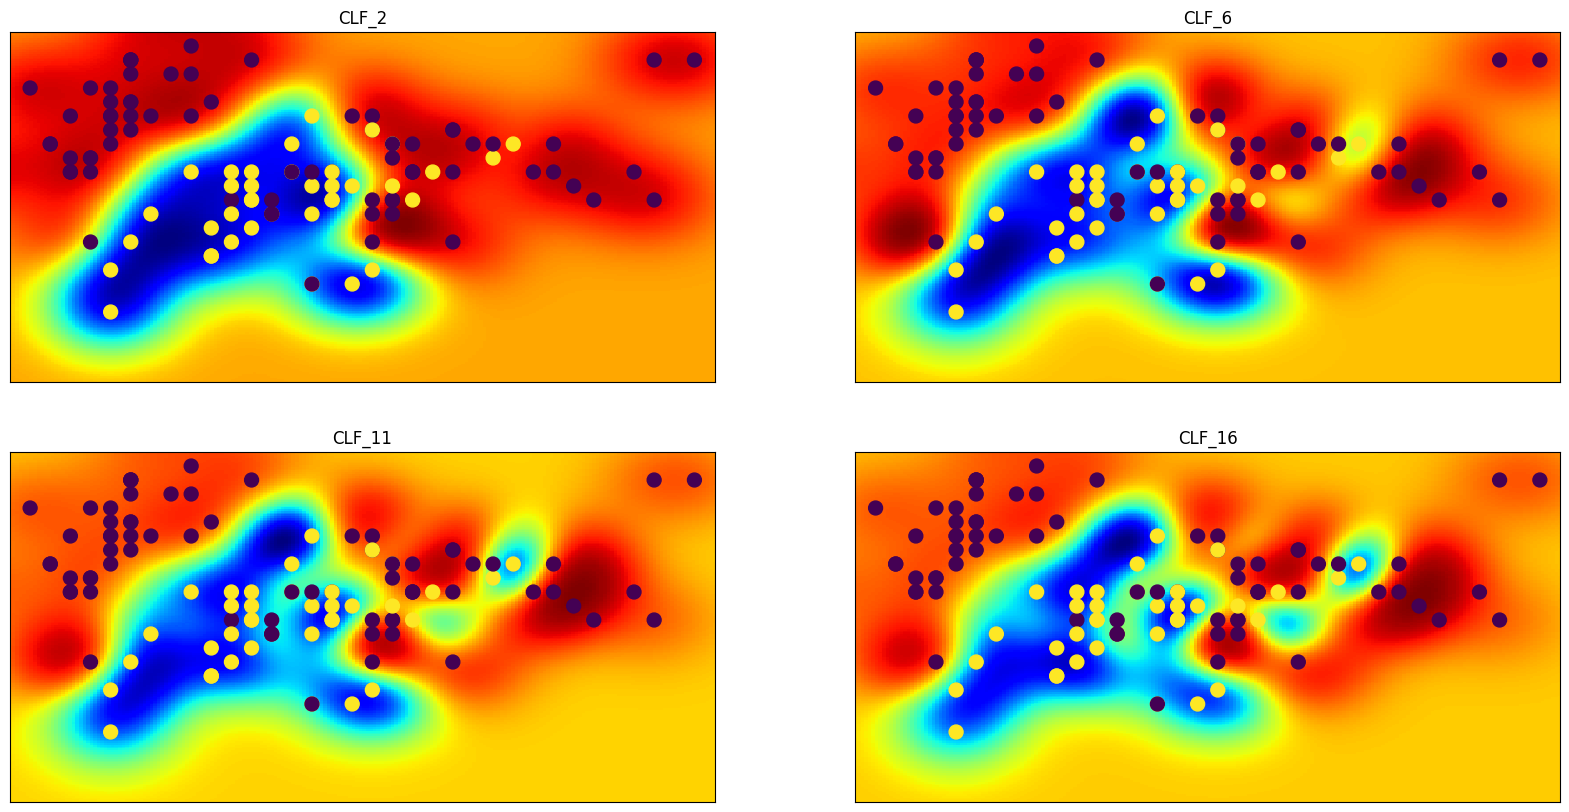

In [227]:
# visualize the decision functions of the four different classifiers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

... and draw the ROC curves.

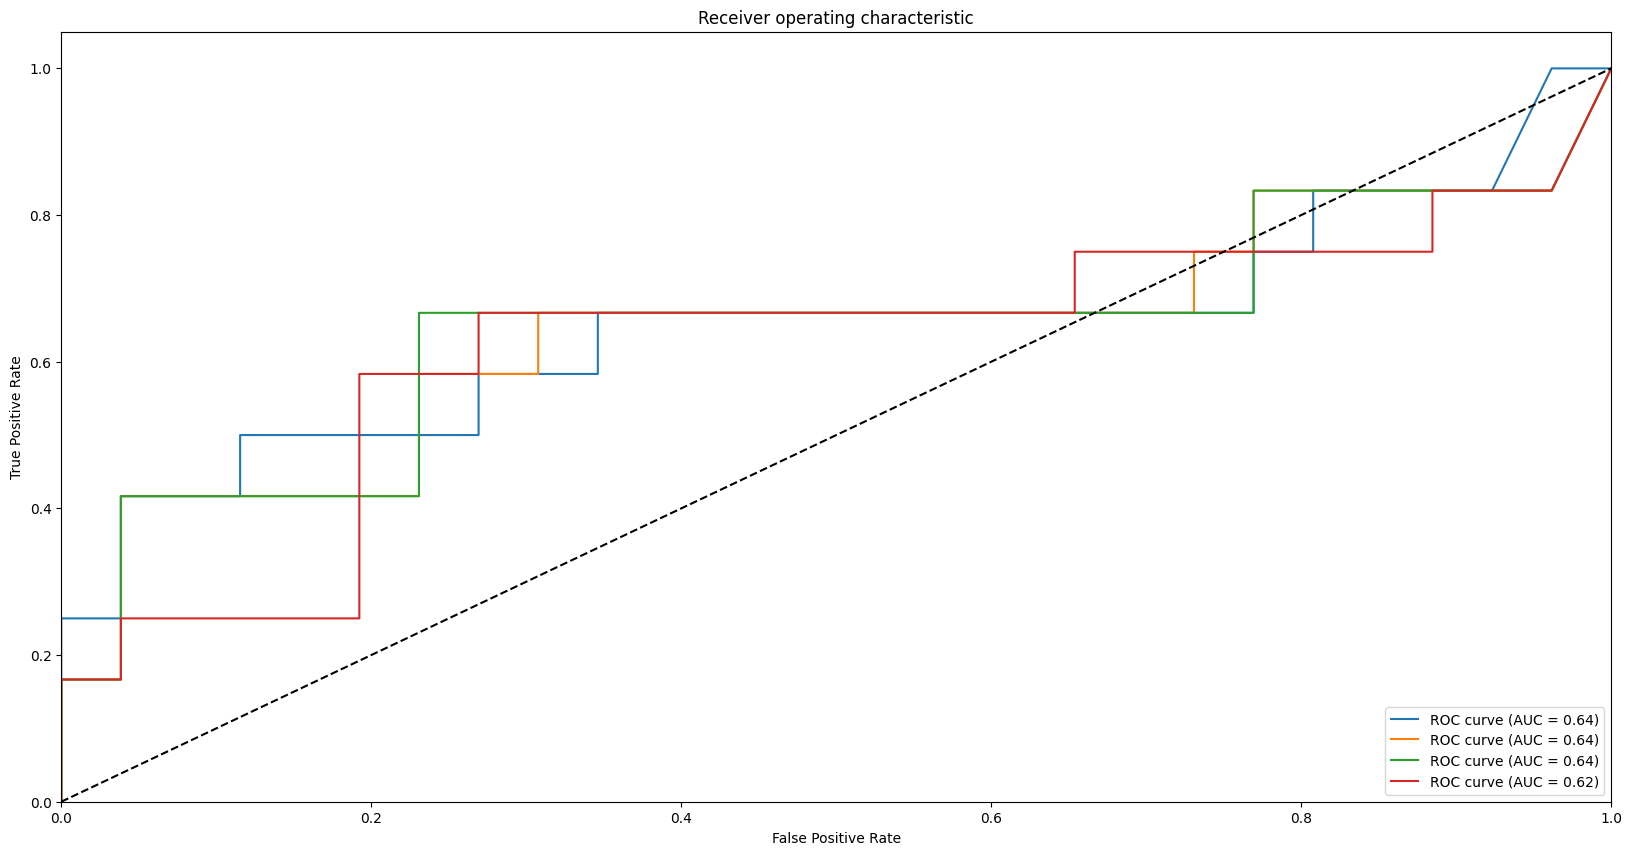

In [228]:
# draw the roc curves:

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curves(fprs, tprs)

## 2. Hyperparameter Tuning

Many models have hyperparameters, parameters that can't directly be estimated from the data. They have to be manually tuned by the practioner, because there is no analytical formula available to calculate an appropriate value. One example is the regularization parameter $C$ in SVMs.

#### Exercise 2.1 (Nested cross-validation)

Train a SVM classifier for the detection of iris versicolor again, but this time with a proper tuning of the regularization parameter $C$ (you may set the gamma parameter to 10 again). Select a reasonable range of parameter values for $C$ and implement a nested cross-validation (as shown on the slides) by yourself. 

You can use the following helper function that creates a list of masks. Each mask can be used as an index set to select the test samples. The function accepts the number of samples *num_samples* in the dataset and the desired number of folds *k* as input parameters. Since the data is sorted by the labels the k-fold CV will likely have trouble with class imbalances in the some cases. So you should randomly shuffle the data before applying the masks.

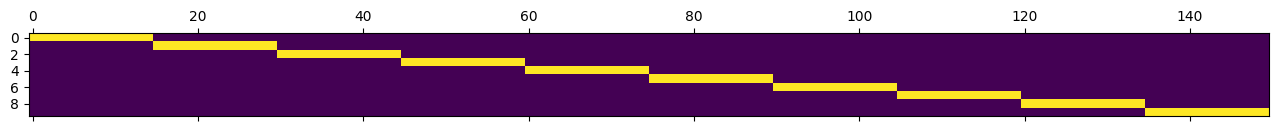

In [180]:
# helper function to create k-fold train-test-splits
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples / k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*int(fold_size):(i+1)*int(fold_size)] = True
        masks.append(mask)
        
    return masks

# visualization of the splits created by 'create_kfold_mask'
masks = create_kfold_mask(150, 10)
plt.matshow(masks)
plt.show()

In [284]:
lmbds = [0.01, 0.1, 1.0, 10.0, 100.0]
best_lmbds = dict()
risks = dict()

X_train = X_versi
y_test = y_versi

for i, mask in enumerate(masks):
    testing_index = np.where(mask==True)
    high_sc = 0
    
    for lmbd in lmbds:
        # New testing data has to be from the remaining elements
        X_train_sub = (np.delete(X_train,testing_index, axis = 0))
        y_test_sub = (np.delete(y_test,testing_index, axis = 0))
        sub_masks = create_kfold_mask(135,9)
        scores = []
    
        for sub_mask in sub_masks:
            X_eval_in = X_train_sub[np.where(sub_mask==True)]
            X_train_in = X_train_sub[np.where(sub_mask==False)]
            y_eval_in = y_test_sub[np.where(sub_mask==True)]
            y_train_in = y_test_sub[np.where(sub_mask==False)]
            svm = SVC(gamma = 10, C = lmbd, probability = True)
            svm.fit(X_train_in,y_train_in)
            preds = svm.predict(X_eval_in)
            score = metrics.accuracy_score(y_eval_in,preds)
            scores.append(score)
        if np.mean(scores) > high_sc:
            high_sc = np.mean(scores)
            best_lmbds[i] = lmbd
    
    opt_lmbd = best_lmbds[i]
    X_eval_out = X_train[np.where(mask==True)]
    X_train_out = X_train[np.where(mask==False)]
    y_eval_out = y_test[np.where(mask==True)]
    y_train_out = y_test[np.where(mask==False)]

    svm = SVC(gamma = 10, C = opt_lmbd, probability = True)
    svm.fit(X_train_out,y_train_out)
    preds = svm.predict(X_eval_out)
    score = metrics.accuracy_score(y_eval_out,preds)
    risks[i] = score

opt_risk = np.mean(list(risks.values()))

# Getting the optimal Lambda, by training on whole data for each value of lambda, and using that lambda, that gave the most optimal avg score on the whole of masked data.
lmbd_risks = dict()
for lmbd in lmbds:
    rsk = []
    for i, mask in enumerate(masks):
        X_eval_out = X_train[np.where(mask==True)]
        X_train_out = X_train[np.where(mask==False)]
        y_eval_out = y_test[np.where(mask==True)]
        y_train_out = y_test[np.where(mask==False)]
        
        svm = SVC(gamma = 10, C = lmbd, probability = True)
        svm.fit(X_train_out,y_train_out)
        preds = svm.predict(X_eval_out)
        score = metrics.accuracy_score(y_eval_out,preds)
        rsk.append(score)
    
    lmbd_risks[lmbd] = np.mean(rsk)

lmbd_risks = dict(sorted(lmbd_risks.items(),key = lambda x: x[1],reverse =True))
opt_lmbd = max(lmbd_risks,key = lmbd_risks.get)

# Training on whole data with the opt_lmbd, to get the best model
svm = SVC(gamma = 10, C = opt_lmbd, probability = True)
svm.fit(X_train, y_test)

average_lmbd = np.mean(list(best_lmbds.values()))
print("best Cs:")
print(list(best_lmbds.values()))
print("Ex Risk k:")
print(list(risks.values()))

print("Avg lambda (C): " + str(average_lmbd))
print("Avg accuracy: " + str(opt_risk))
svm

best Cs:
[10.0, 10.0, 10.0, 100.0, 0.01, 0.01, 0.01, 10.0, 10.0, 10.0]
Ex Risk k:
[1.0, 1.0, 1.0, 0.5333333333333333, 0.0, 0.0, 0.3333333333333333, 0.6, 0.6666666666666666, 0.26666666666666666]
Avg lambda (C): 16.003
Avg accuracy: 0.54


SVC(C=10.0, gamma=10, probability=True)

In [254]:
mks = create_kfold_mask(150,10)

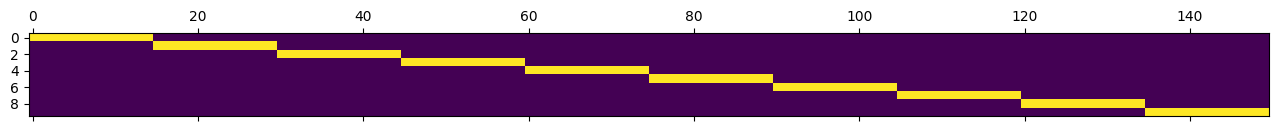

In [252]:
plt.matshow(mks)
plt.show()

In [266]:
testing_index = np.where(mks[0] == True)
X_train_sub = (np.delete(X_train,testing_index,axis = 0))

In [286]:
from sklearn.utils import shuffle

X_data, y_data = shuffle(iris.data, iris.target, random_state = 0)

#Risk not really used in practice to evaulate performance, rather AUC or accuracy for binary classification

def own_nested_cross_val(X_data, y_data, k):
    masks = create_kfold_mask(len(y_data), k)
    cValues = [0.01, 0.1, 1.0, 10.0, 100.0]
    bestCs = []
    Ex_Risk_k = []
    average_lmbd = 0

    for i in range(k):
        Avg_Risk_C = [] #average of exp-risks-split-c

        for c_val in cValues:
            train_tune_range = list(range(k))
            train_tune_range.remove(i) # remove test fold

            Ex_Risks_Split_C = [] #For one c_val the corresponding risks for the different test und train splitts

            for j in train_tune_range:
                trainRange = train_tune_range.copy()
                trainRange.remove(j)

                #get the training set of data
                train_mask = np.array([], dtype="int32")
                for l in trainRange:
                    train_mask = np.concatenate((train_mask, np.nonzero(masks[l])[0]),axis=0)
                X_temp = X_data[train_mask]
                y_temp = y_data[train_mask]
                
                #fit the data
                clf_svm_temp = SVC(gamma=10, C=c_val)
                clf_svm_temp.fit(X_temp, y_temp)

                #get the tuning set of data
                X_temp_tune = X_data[masks[j]]
                y_temp_tune = y_data[masks[j]]

                #test the risk of the c_val
                emp_risk = clf_svm_temp.score(X_temp_tune, y_temp_tune) #uses accuracy instead of empirical risk directly
                Ex_Risks_Split_C.append(emp_risk)

            #insert average risk per c_val in array
            Avg_Risk_C.append(np.mean(Ex_Risks_Split_C))

        #find max c
        bestCs.append(cValues[np.argmax(Avg_Risk_C)]) #max since using accuracy

        #get the training set of data 
        train_tune_mask = np.array([], dtype="int32")
        for l in train_tune_range:
            train_tune_mask = np.concatenate((train_tune_mask,np.nonzero(masks[l])[0]),axis=0)
        X_temp_outer_rim = X_data[train_tune_mask]
        y_temp_outer_rim = y_data[train_tune_mask]

        #fit the data
        clf_svm_temp_outer_rim = SVC(gamma=10, C=bestCs[i])
        clf_svm_temp_outer_rim.fit(X_temp_outer_rim, y_temp_outer_rim)

        #get the tuning set of data
        X_temp_tune_outer_rim = X_data[masks[i]]
        y_temp_tune_outer_rim = y_data[masks[i]]

        #test the risk of the c_val
        emp_risk_outer_rim = clf_svm_temp_outer_rim.score(X_temp_tune_outer_rim, y_temp_tune_outer_rim)
        Ex_Risk_k.append(emp_risk_outer_rim)

    average_lmbd = np.mean(bestCs)
    average_risk = np.mean(Ex_Risk_k)
    
    print("best Cs:")
    print(bestCs)
    print("Ex Risk k:")
    print(Ex_Risk_k)

    #fit the data
    clf_svm_final = SVC(gamma=10, C=average_lmbd)
    clf_svm_final.fit(X_data, y_data)
    
    print("Avg lambda (C): " + str(average_lmbd))
    print("Avg accuracy: " + str(average_risk))
    
    #return the risk and the model
    return clf_svm_final, average_risk


clf_svm_final,_ = own_nested_cross_val(X_data, y_data, 5);

best Cs:
[1.0, 10.0, 10.0, 10.0, 1.0]
Ex Risk k:
[0.9666666666666667, 0.9, 0.9666666666666667, 0.9666666666666667, 0.8666666666666667]
Avg lambda (C): 6.4
Avg accuracy: 0.9333333333333333


In [287]:
clf_svm_final

SVC(C=6.4, gamma=10)